In [1]:
import os, sys

os.chdir('Petreanu_MEI_generation')
sys.path.append(os.getcwd())

print(os.getcwd())

d:\Python\Anastasia\Petreanu Lab\Petreanu_MEI_generation


In [2]:
import torch 
import umap
import pandas as pd

In [5]:
run_name_base_V1 = 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor'
run_name_base_PM = 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor'

# find subfolders for each of the above where the directory starts with LPE
run_names_V1 = [x for x in os.listdir(run_name_base_V1) if x.startswith('LPE')]
run_names_PM = [x for x in os.listdir(run_name_base_PM) if x.startswith('LPE')]

# add the full path to the run names
run_names_V1 = [os.path.join(run_name_base_V1, x) for x in run_names_V1]
run_names_PM = [os.path.join(run_name_base_PM, x) for x in run_names_PM]

run_names_V1

['runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE09665-LPE09665_2023_03_20-0',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10883-LPE10883_2023_10_23-0',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10883-LPE10883_2023_10_31-0',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10884-LPE10884_2023_10_12-0',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10885-LPE10885_2023_10_20-0',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10919-LPE10919_2023_11_09-0',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11086-LPE11086_2023_12_16-0',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11086-LPE11086_2024_01_09-0',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11495-LPE11495_2024_02_29-0',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11998-LPE11998_2024_05_08-0',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE12223-LPE12223_202

In [12]:
# handmade, to find the best MEI predictions for each run for each area

best_models_V1 = [2, 2, 1, 2, 1, 4, 2, 1, 2, 2, 4, 2, 4]
best_models_PM = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

# assert each run has a best model
assert len(run_names_V1) == len(best_models_V1), f'{len(run_names_V1)} != {len(best_models_V1)}'
assert len(run_names_PM) == len(best_models_PM), f'{len(run_names_PM)} != {len(best_models_PM)}'

# make paths for each best model

best_model_paths_V1 = [os.path.join(run_names_V1[i], f'meis_model_{best_models_V1[i]}.pth') for i in range(len(run_names_V1))]
best_model_paths_PM = [os.path.join(run_names_PM[i], f'meis_model_{best_models_PM[i]}.pth') for i in range(len(run_names_PM))]
best_model_paths_V1

['runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE09665-LPE09665_2023_03_20-0\\meis_model_2.pth',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10883-LPE10883_2023_10_23-0\\meis_model_2.pth',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10883-LPE10883_2023_10_31-0\\meis_model_1.pth',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10884-LPE10884_2023_10_12-0\\meis_model_2.pth',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10885-LPE10885_2023_10_20-0\\meis_model_1.pth',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10919-LPE10919_2023_11_09-0\\meis_model_4.pth',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11086-LPE11086_2023_12_16-0\\meis_model_2.pth',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11086-LPE11086_2024_01_09-0\\meis_model_1.pth',
 'runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11495-LPE11495_2024_02_29-0\\meis_model_2.pth',
 'runs/V1_

In [17]:
# Load the data

meis_v1 = [torch.load(x) for x in best_model_paths_V1]
meis_pm = [torch.load(x) for x in best_model_paths_PM]

# expand the sublists
meis_v1 = [item for sublist in meis_v1 for item in sublist]
meis_pm = [item for sublist in meis_pm for item in sublist]

meis = []
meis.extend(meis_v1)
meis.extend(meis_pm)

num_v1_meis = len(meis_v1)
num_pm_meis = len(meis_pm)

print(f'Loaded {len(meis)} MEIs')

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_28044\272466917.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meis_v1 = [torch.load(x) for x in best_model_paths_V

Loaded 2056 MEIs


In [20]:
len(meis_v1), meis_v1[0].shape

(1028, torch.Size([1, 4, 68, 135]))

In [21]:
# meis_v1 = torch.load('runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor/meis_model_4.pth')
# meis_pm = torch.load('runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor/meis_model_2.pth')

# meis = []
# meis.extend(meis_v1)
# meis.extend(meis_pm)

# num_v1_meis = len(meis_v1)
# num_pm_meis = len(meis_pm)

# print(f'len meis, {len(meis)}')

In [22]:
meis = [mei[0][0, :, :].detach().cpu().numpy() for mei in meis]

In [23]:
meis[0].shape

(68, 135)

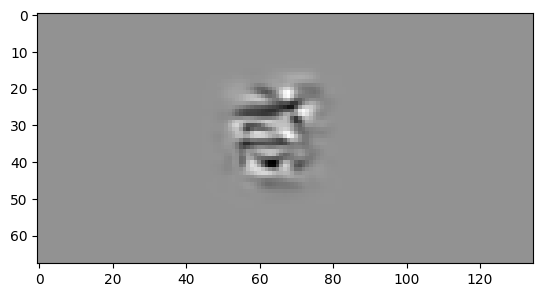

In [24]:
from matplotlib import pyplot as plt
plt.imshow(meis[0], cmap='gray')
plt.show()

In [27]:
import numpy as np

epsilon=0.001
extracted_regions = []
images_to_remove = []

for i, img in enumerate(meis):
    # Mask for values that are not "close to zero" (i.e., values greater than epsilon in absolute value)
    mask = np.abs(img) > epsilon

    # Get the row and column indices of the non-zero values based on the mask
    rows, cols = np.nonzero(mask)

    # If no non-zero pixels are found (all values are considered zero), append None
    if len(rows) == 0 or len(cols) == 0:
        # extracted_regions.append(None)
        images_to_remove.append(i)
        continue

    # Get the bounding box (min/max row and column indices)
    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)

    # Extract the region within the bounding box
    region = img[min_row:max_row+1, min_col:max_col+1]

    # do not append region if it is larger than 60 x 60 = 3600 pixels
    if region.shape[0] * region.shape[1] > 3600:
        # extracted_regions.append(None)
        images_to_remove.append(i)
    else:
        extracted_regions.append(region)

print(f'Removed {len(images_to_remove)} images')
print(f'Kept {len(extracted_regions)} images')

Removed 76 images
Kept 1980 images


In [28]:
# For all extracted regions, prepend and append 0 values such that the shape is the same as for the largest

max_shape = max([region.shape for region in extracted_regions if region is not None])

for i, region in enumerate(extracted_regions):
    if region is None:
        continue

    # Get the shape of the region
    shape = region.shape

    # Calculate the number of rows and columns to prepend/append
    rows_to_prepend = (max_shape[0] - shape[0]) // 2
    rows_to_append = max_shape[0] - shape[0] - rows_to_prepend

    cols_to_prepend = (max_shape[1] - shape[1]) // 2
    cols_to_append = max_shape[1] - shape[1] - cols_to_prepend

    # Prepend and append rows and columns with zeros
    extracted_regions[i] = np.pad(region, ((rows_to_prepend, rows_to_append), (cols_to_prepend, cols_to_append)), mode='constant')

print(max_shape)

(41, 41)


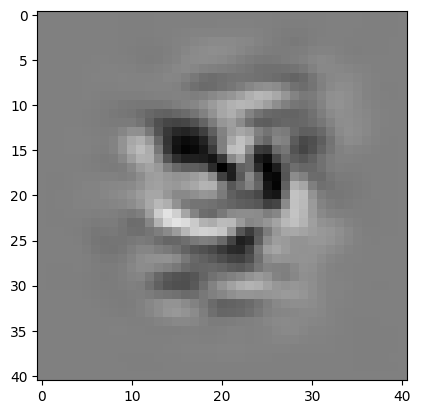

In [157]:
plt.imshow(extracted_regions[1], cmap='gray', vmin=-1, vmax=1)
plt.show()

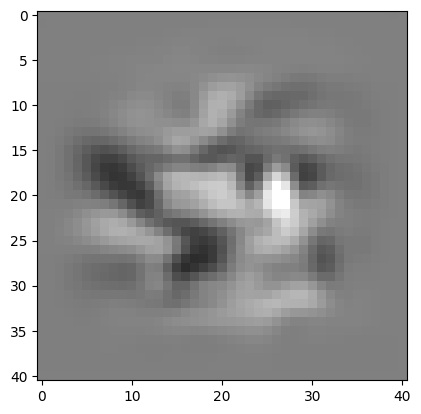

In [158]:
plt.imshow(extracted_regions[-2], cmap='gray', vmin=-1, vmax=1)
plt.show()

In [30]:
umapper = umap.UMAP()

In [31]:
# flattened_meis = [mei.flatten() for mei in meis]
flattened_meis = [mei.flatten() for mei in extracted_regions if mei is not None]

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
flattened_scaled_meis = scaler.fit_transform(flattened_meis)

In [33]:
embeddings = umapper.fit_transform(flattened_scaled_meis)

In [34]:
markers = ['o', 'x']

class_list = []
class_list.extend(['v1' for i in range(num_v1_meis)])
class_list.extend(['pm' for i in range(num_pm_meis)])
class_list = [0 if i == 'v1' else i for i in class_list]
class_list = [1 if i == 'pm' else i for i in class_list]

# remove indices of images that were removed

class_list = [class_list[i] for i in range(len(class_list)) if i not in images_to_remove]

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_28044\3508165336.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='Spectral')


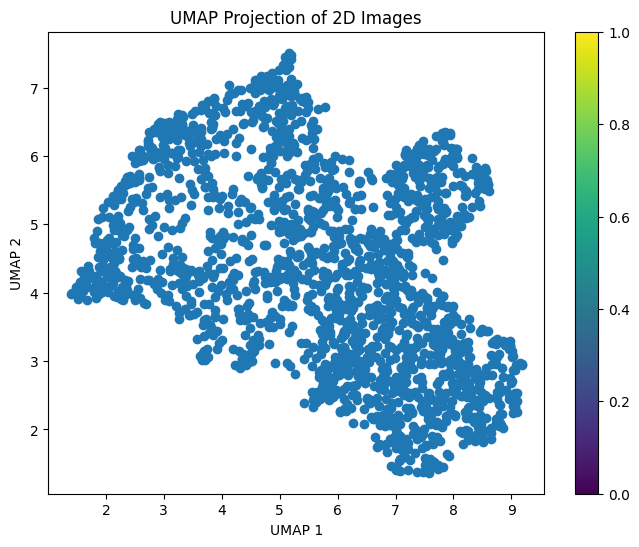

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='Spectral')
plt.title('UMAP Projection of 2D Images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_28044\2899108253.py:3: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(embeddings[i, 0], embeddings[i, 1],


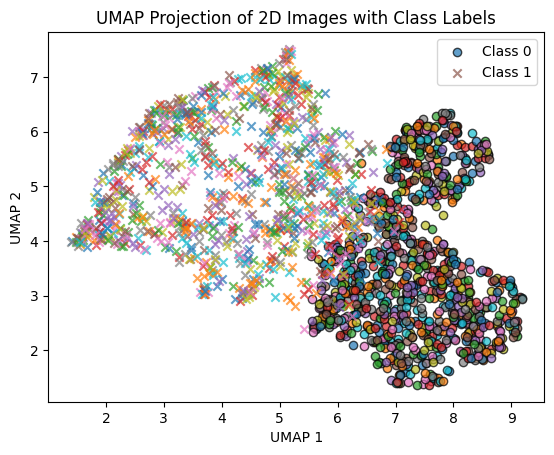

In [36]:
added_labels = []
for i, label in enumerate(class_list):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                marker=markers[label], label=f'Class {label}' if label not in added_labels else "", 
                alpha=0.7, edgecolors='k')
    added_labels.append(label)

plt.title('UMAP Projection of 2D Images with Class Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Avoid duplicate legend entries
plt.legend(loc='upper right')

plt.show()

d:\anaconda3\envs\molanalysis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


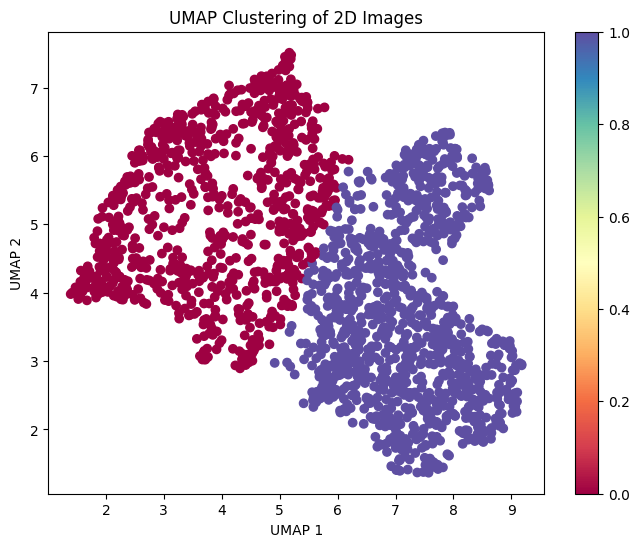

In [37]:
from sklearn.cluster import KMeans

# Fit KMeans on UMAP embeddings
kmeans = KMeans(n_clusters=2)  # Choose the number of clusters you want
kmeans.fit(embeddings)

# Get the cluster labels
labels = kmeans.labels_

# Plot the clusters with different colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='Spectral')
plt.title('UMAP Clustering of 2D Images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter)
plt.show()


C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_28044\1517055028.py:24: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(embeddings[i, 0], embeddings[i, 1],


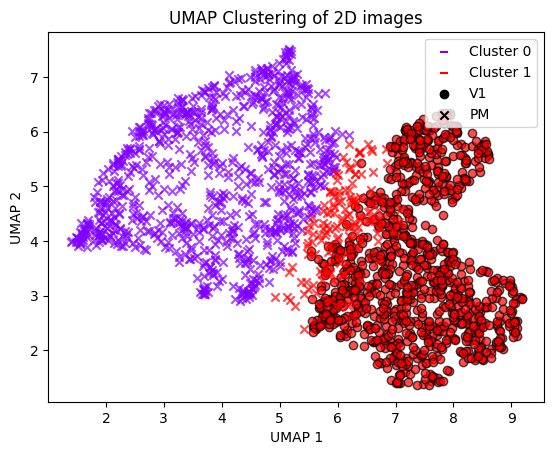

In [117]:
from sklearn.cluster import KMeans, DBSCAN
from matplotlib.pyplot import cm
import numpy as np

num_clusters = 2

# Fit KMeans on UMAP embeddings
# kmeans = KMeans(n_clusters=num_clusters)  # Choose the number of clusters you want
# kmeans.fit(embeddings)

# Get the cluster labels
labels = kmeans.labels_

# labels = dbscan_labels


color = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

added_labels = []
for i, label in enumerate(class_list):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                marker=markers[label], 
                alpha=0.7, edgecolors='k', color=color[labels[i]])
    added_labels.append(label)

legend_labels = ['V1', 'PM']
for i in range(num_clusters):
    plt.scatter([], [], color=color[i], label=f'Cluster {i}', marker='_')
for i in range(2):
    plt.scatter([], [], marker=markers[i], label=legend_labels[i], color='black')


plt.title('UMAP Clustering of 2D images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Avoid duplicate legend entries
plt.legend(loc='upper right')

plt.show()

In [148]:
dbscan = DBSCAN(eps=0.35, min_samples=25)
labels_dbscan = dbscan.fit_predict(embeddings)

print(np.unique(labels_dbscan))
labels_dbscan

[-1  0  1  2  3  4]


array([0, 0, 0, ..., 0, 0, 2], dtype=int64)

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_28044\405428721.py:7: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(embeddings[i, 0], embeddings[i, 1],


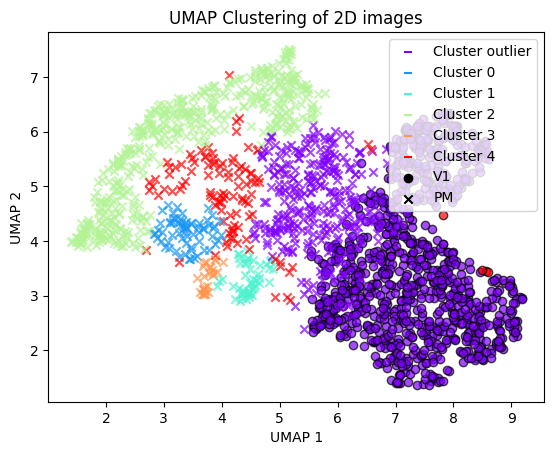

In [151]:
color = cm.rainbow(np.linspace(0, 1, len(np.unique(labels_dbscan))))

num_clusters_dbscan = len(np.unique(labels_dbscan))

added_labels = []
for i, label in enumerate(class_list):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                marker=markers[label], 
                alpha=0.7, edgecolors='k', color=color[labels_dbscan[i]])
    added_labels.append(label)

legend_labels = ['V1', 'PM']
for i, cl_id in enumerate(np.unique(labels_dbscan)):
    plt.scatter([], [], color=color[i], label=f'Cluster {cl_id if cl_id != -1 else "outlier"}', marker='_')
for i in range(2):
    plt.scatter([], [], marker=markers[i], label=legend_labels[i], color='black')


plt.title('UMAP Clustering of 2D images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Avoid duplicate legend entries
plt.legend(loc='upper right')

plt.show()

# Add in labeled and unlabeled cells

In [82]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
from sensorium.utility.training import read_config
from sensorium.utility import submission
from nnfabrik.builder import get_data, get_model
from sensorium.models.ensemble import EnsemblePrediction
from sensorium.utility import get_correlations
from sensorium.utility.measure_helpers import get_df_for_scores
from loaddata.session_info import load_sessions
from utils.plotting_style import *  # get all the fixed color schemes
from utils.imagelib import load_natural_images
from loaddata.get_data_folder import get_local_drive
from utils.pair_lib import compute_pairwise_anatomical_distance
from utils.rf_lib import *
import pickle as pkl

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'Petreanu_MEI_generation' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('Petreanu_MEI_generation')[0] + 'Petreanu_MEI_generation'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the Petreanu_MEI_generation folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

run_config = read_config('run_config.yaml') # Must be set
# INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
INPUT_FOLDER = 'D:/Procdata/IM'
# sessions_to_keep = [['LPE13959', '2025_02_24']]
# sessions_to_keep = 'all'
sessions_to_keep = [['LPE09665', '2023_03_20'],
       ['LPE10883', '2023_10_23'],
       ['LPE10883', '2023_10_31'],
       ['LPE10884', '2023_10_12'],
       ['LPE10885', '2023_10_20'],
       ['LPE10919', '2023_11_09'],
       ['LPE11086', '2023_12_16'],
       ['LPE11086', '2024_01_09'],
       ['LPE11495', '2024_02_29'],
       ['LPE11998', '2024_05_08'],
       ['LPE12223', '2024_06_11'],
       ['LPE13959', '2025_02_17'],
       ['LPE13959', '2025_02_24']]

# sessions_to_keep = np.array(sessions_to_keep)

try: 
    session_folders
except NameError:
    # First level
    session_folders = [os.path.join(INPUT_FOLDER, name) for name in os.listdir(
        INPUT_FOLDER) if os.path.isdir(os.path.join(INPUT_FOLDER, name)) and not "merged_data" in name]
    session_folders = [x.replace("\\", "/") for x in session_folders]
    # Second level
    files = [[session_folder, os.path.join(session_folder, name).replace('\\', '/')] for session_folder in session_folders for name in os.listdir(
        session_folder) if os.path.isdir(os.path.join(session_folder, name)) and not "merged_data" in name]
    # only get last value after /
    session_list = [[session_folder.split("/")[-1], name.split("/")[-1]]
                    for session_folder, name in files]

    # drop ['LPE10919', '2023_11_08'] because the data is not converted yet
    session_list = [x for x in session_list if x != ['LPE10919', '2023_11_08']]

if not isinstance(sessions_to_keep, str):
    sessions_to_keep = [tuple(x) for x in sessions_to_keep]
    session_list = [tuple(x) for x in session_list]
    session_list = [x for x in session_list if x in sessions_to_keep]
    session_list = [list(x) for x in session_list]
elif sessions_to_keep == 'all':
    pass

session_list = np.array(session_list)

assert len(session_list) == len(best_model_paths_V1) == len(best_model_paths_PM), f'{len(session_list)} != {len(best_model_paths_V1)} != {len(best_model_paths_PM)}'

print(session_list)

[['LPE09665' '2023_03_20']
 ['LPE10883' '2023_10_23']
 ['LPE10883' '2023_10_31']
 ['LPE10884' '2023_10_12']
 ['LPE10885' '2023_10_20']
 ['LPE10919' '2023_11_09']
 ['LPE11086' '2023_12_16']
 ['LPE11086' '2024_01_09']
 ['LPE11495' '2024_02_29']
 ['LPE11998' '2024_05_08']
 ['LPE12223' '2024_06_11']
 ['LPE13959' '2025_02_17']
 ['LPE13959' '2025_02_24']]


In [83]:
sessions, nSessions = load_sessions(protocol='IM', session_list=session_list, data_folder = INPUT_FOLDER)

for ises in range(nSessions):    # Load proper data and compute average trial responses:
    sessions[ises].load_respmat(calciumversion='deconv', keepraw=False)

sessions = compute_pairwise_anatomical_distance(sessions)
sessions = smooth_rf(sessions,radius=75,rf_type='Fneu')
sessions = exclude_outlier_rf(sessions) 
sessions = replace_smooth_with_Fsig(sessions) 

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing pairwise anatomical distance for each session: 100%|██████████| 13/13 [00:01<00:00,  9.46it/s]
Setting outlier RFs to NaN: 100%|██████████| 13/13 [00:00<00:00, 2601.06it/s]


In [105]:
# celldata = sessions[0].celldata
# celldata

,iscell,iscell_prob,skew,radius,npix_soma,npix,xloc,...,recombinase,session_id,rf_az_Fsmooth,rf_el_Fsmooth,rf_sx_Fsmooth,rf_sy_Fsmooth,rf_r2_Fsmooth
0,1.0,0.917326,5.980925,8.389091,157.0,172.0,465.234375,...,non,LPE13959_2025_02_24,99.513110,31.205298,NaN,NaN,1.000000
1,1.0,0.988401,8.282103,7.690224,143.0,172.0,118.359375,...,non,LPE13959_2025_02_24,73.542776,28.001962,NaN,NaN,1.000000
2,1.0,0.996226,9.465027,5.839460,106.0,127.0,235.546875,...,non,LPE13959_2025_02_24,77.532161,30.886447,NaN,NaN,1.000000
3,1.0,0.971806,7.692322,6.673438,105.0,136.0,544.921875,...,cre,LPE13959_2025_02_24,91.780238,33.942454,38.915069,6.41469,0.231648
4,1.0,0.984217,6.789249,6.524613,122.0,145.0,385.546875,...,cre,LPE13959_2025_02_24,92.686224,31.389018,NaN,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,1.0,0.627150,1.241703,4.294106,65.0,77.0,452.343750,...,non,LPE13959_2025_02_24,NaN,NaN,NaN,NaN,NaN
3632,1.0,0.851016,0.618288,5.141607,80.0,132.0,441.796875,...,non,LPE13959_2025_02_24,NaN,NaN,NaN,NaN,NaN
3633,1.0,0.628065,1.073125,5.056850,56.0,68.0,450.000000,...,non,LPE13959_2025_02_24,NaN,NaN,NaN,NaN,NaN
3634,1.0,0.836071,0.616728,5.054649,76.0,106.0,360.937500,...,non,LPE13959_2025_02_24,NaN,NaN,NaN,NaN,NaN


In [84]:
celldatas = [session.celldata for session in sessions]
celldata = pd.concat(celldatas)

In [85]:
celldata.columns

Index(['iscell', 'iscell_prob', 'skew', 'radius', 'npix_soma', 'npix', 'xloc', 'yloc', 'redcell', 'frac_of_ROI_red', 'frac_red_in_ROI', 'chan2_prob', 'nredcells', 'plane_idx', 'roi_idx', 'plane_in_roi_idx', 'roi_name', 'depth', 'power_mw', 'meanF', 'meanF_chan2', 'noise_level', 'event_rate', 'cell_id', 'layer', 'recombinase', 'session_id', 'labeled', 'arealabel', 'rf_az_F', 'rf_el_F', 'rf_sx_F', 'rf_sy_F', 'rf_r2_F', 'rf_az_Fneu', 'rf_el_Fneu', 'rf_sx_Fneu', 'rf_sy_Fneu', 'rf_r2_Fneu', 'rf_az_Fsmooth', 'rf_el_Fsmooth', 'rf_sx_Fsmooth', 'rf_sy_Fsmooth', 'rf_r2_Fsmooth'], dtype='object')

In [120]:
# cell_ids_v1 = pd.read_csv('runs/V1_MEI_in_vivo_validation_with_grid_mean_predictor/results/cell_ids.csv')
# cell_ids_pm = pd.read_csv('runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor/results/cell_ids.csv')

# cell_ids_v1['index'] = cell_ids_v1.index
# cell_ids_pm['index'] = cell_ids_pm.index

In [94]:
run_names_PM

['runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE09665-LPE09665_2023_03_20-0',
 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10883-LPE10883_2023_10_23-0',
 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10883-LPE10883_2023_10_31-0',
 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10884-LPE10884_2023_10_12-0',
 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10885-LPE10885_2023_10_20-0',
 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE10919-LPE10919_2023_11_09-0',
 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11086-LPE11086_2023_12_16-0',
 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11086-LPE11086_2024_01_09-0',
 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11495-LPE11495_2024_02_29-0',
 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE11998-LPE11998_2024_05_08-0',
 'runs/PM_MEI_in_vivo_validation_with_grid_mean_predictor\\LPE12223-LPE12223_202

In [222]:
cell_ids_v1 = [pd.read_csv(os.path.join(x, 'results/cell_ids.csv')) for x in run_names_V1]
cell_ids_pm = [pd.read_csv(os.path.join(x, 'results/cell_ids.csv')) for x in run_names_PM]

cell_ids_v1 = pd.concat(cell_ids_v1)
cell_ids_pm = pd.concat(cell_ids_pm)

cell_ids_v1['index'] = cell_ids_v1.index
cell_ids_pm['index'] = cell_ids_pm.index

cell_ids_v1['area'] = 'V1'
cell_ids_pm['area'] = 'PM'

cell_ids = pd.concat([cell_ids_v1, cell_ids_pm])

print(len(cell_ids_v1), len(cell_ids_pm))

In [101]:
cell_ids_v1

,cell_id,neuron_idx,index,area
0,LPE09665_2023_03_20_0_0051,50,0,v1
1,LPE09665_2023_03_20_1_0003,84,1,v1
2,LPE09665_2023_03_20_0_0002,2,2,v1
3,LPE09665_2023_03_20_0_0005,5,3,v1
4,LPE09665_2023_03_20_3_0040,401,4,v1
...,...,...,...,...
70,LPE13959_2025_02_24_2_0492,1630,70,v1
71,LPE13959_2025_02_24_1_0008,546,71,v1
72,LPE13959_2025_02_24_2_0455,1611,72,v1
73,LPE13959_2025_02_24_0_0126,126,73,v1


In [103]:
celldata_v1 = celldata.merge(cell_ids_v1, on='cell_id', how='right')
celldata_pm = celldata.merge(cell_ids_pm, on='cell_id', how='right')
celldata_v1

,iscell,iscell_prob,skew,radius,npix_soma,npix,xloc,...,rf_az_Fsmooth,rf_el_Fsmooth,rf_sx_Fsmooth,rf_sy_Fsmooth,rf_r2_Fsmooth,neuron_idx,index
0,1.0,0.967593,1.541831,5.111665,101.0,139.0,262.000000,...,NaN,NaN,NaN,NaN,NaN,50,0
1,1.0,0.802373,1.814437,5.200246,98.0,121.0,303.000000,...,NaN,NaN,NaN,NaN,NaN,84,1
2,1.0,0.956664,2.428403,7.613365,135.0,166.0,306.000000,...,NaN,NaN,NaN,NaN,NaN,2,2
3,1.0,0.980572,1.637873,6.422160,110.0,189.0,250.000000,...,NaN,NaN,NaN,NaN,NaN,5,3
4,1.0,0.566371,1.278736,3.831529,53.0,62.0,42.000000,...,NaN,NaN,NaN,NaN,NaN,401,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,1.0,0.567731,0.798199,5.224855,102.0,118.0,577.734375,...,111.222352,30.382628,12.187503,7.496195,0.386349,1630,70
1024,1.0,0.965399,4.008502,4.916511,99.0,145.0,38.671875,...,71.174864,26.976253,NaN,NaN,1.000000,546,71
1025,1.0,0.540202,2.363200,4.167052,62.0,81.0,189.843750,...,82.125358,26.471357,NaN,NaN,1.000000,1611,72
1026,1.0,0.948876,3.081385,4.582008,78.0,181.0,362.109375,...,89.782762,20.070225,5.969652,7.876448,0.260089,126,73


In [105]:
celldata_full = pd.concat([celldata_v1, celldata_pm], ignore_index=True)
redcells = celldata_full['redcell'].values

# remove indices of images that were removed
redcells = [redcells[i] for i in range(len(redcells)) if i not in images_to_remove]

len(redcells)

1980

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_28044\1827779142.py:5: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(embeddings[i, 0], embeddings[i, 1],


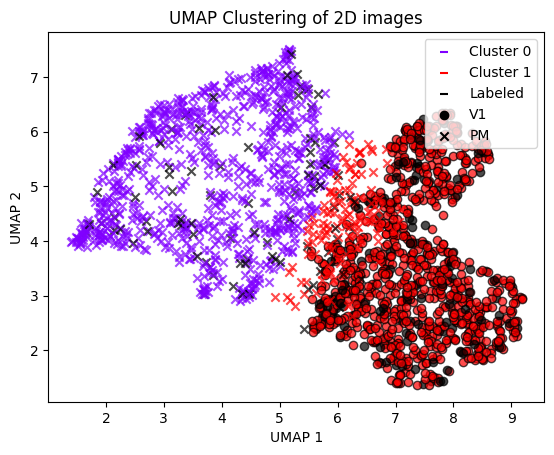

In [108]:
# Plot UMAP images with a separate color for labeled cells where redcell == 1

added_labels = []
for i, (label, redcell) in enumerate(zip(class_list, redcells)):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                marker=markers[label], 
                alpha=0.7, edgecolors='k', color=color[labels[i]] if redcell == 0 else 'black')
    added_labels.append(label)

legend_labels = ['V1', 'PM']
for i in range(num_clusters):
    plt.scatter([], [], color=color[i], label=f'Cluster {i}', marker='_')
plt.scatter([], [], color='black', label='Labeled', marker='_')
for i in range(2):
    plt.scatter([], [], marker=markers[i], label=legend_labels[i], color='black')


plt.title('UMAP Clustering of 2D images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Avoid duplicate legend entries
plt.legend(loc='upper right')

plt.show()

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_28044\2061324772.py:5: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(embeddings[i, 0], embeddings[i, 1],


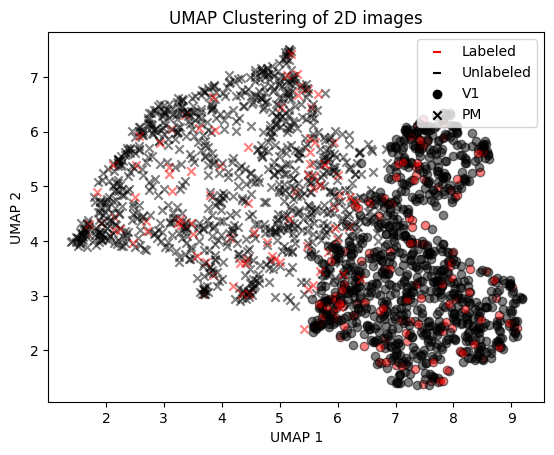

In [115]:
# Plot UMAP images with a separate color for labeled cells where redcell == 1

added_labels = []
for i, (label, redcell) in enumerate(zip(class_list, redcells)):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                marker=markers[label], 
                alpha=0.5, 
                edgecolors='k', 
                # color=color[labels[i]] if redcell == 0 else 'black'
                color = 'red' if redcell == 1 else 'black',
                )
    added_labels.append(label)

legend_labels = ['V1', 'PM']
# for i in range(num_clusters):
#     plt.scatter([], [], color=color[i], label=f'Cluster {i}', marker='_')
plt.scatter([], [], color='red', label='Labeled', marker='_')
plt.scatter([], [], color='black', label='Unlabeled', marker='_')
for i in range(2):
    plt.scatter([], [], marker=markers[i], label=legend_labels[i], color='black')


plt.title('UMAP Clustering of 2D images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Avoid duplicate legend entries
plt.legend(loc='upper right')

plt.show()

More visualizations

In [ ]:
# To visualize the difference in UMAP space, divide the 2D UMAP space into a N x N grid (N=5? at first, then upsample)
# and from each grid select a neuron with high STC and show its MEI at that location (edited) 

In [236]:
# from tqdm.auto import tqdm
# from nnfabrik.builder import get_data, get_model
# from gradient_ascent import gradient_ascent
# from sensorium.utility import get_signal_correlations
# from sensorium.utility.measure_helpers import get_df_for_scores
# from sensorium.utility.training import read_config
# from sensorium.models.ensemble import EnsemblePrediction
# from neuralpredictors.measures.np_functions import corr
# from sensorium.utility.submission import get_data_filetree_loader
# from PIL import Image
# from scipy import stats


# run_config = read_config('run_config.yaml') # Must be set

# # RUN_NAME = run_config['current_vals']['RUN_NAME'] # MUST be set. Creates a subfolder in the runs folder with this name, containing data, saved models, etc. IMPORTANT: all values in this folder WILL be deleted.
# # RUN_FOLDER = run_config['current_vals']['RUN_FOLDER']
# # data_key = f"{run_config['MEIs']['session_id']}-{run_config['MEIs']['session_id']}_{run_config['MEIs']['session_date']}-0"
# # INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
# # data_basepath = f'{INPUT_FOLDER}/'
# # area_of_interest = run_config['current_vals']['data']['area_of_interest']
# # tier = run_config['MEIs']['tier']
# # mei_shape = run_config['MEIs']['shape']
# # num_models = run_config['dev']['num_models']
# # num_meis = run_config['MEIs']['num_meis']
# # num_labeled_cells = run_config['MEIs']['num_labeled_cells']
# # session_id = run_config['MEIs']['session_id']
# # session_date = run_config['MEIs']['session_date']

In [237]:
# dfs = []

# for area_idx, RUN_FOLDER in enumerate([run_name_base_V1, run_name_base_PM]):

#     # ## Restart Kernel after mei-module installation!

#     warnings.filterwarnings('ignore')

#     seed=31415
#     # Loading config only for ensemble 0, because all 5 models have the same config (except
#     # for the seed and dataloader train/validation split)

#     # config_file = 'config_m4_ens0.yaml'
#     config_file = f'{RUN_FOLDER}/config_m4_ens0/config.yaml'
#     config = read_config(config_file)
#     config['model_config']['data_path'] = f'{RUN_FOLDER}/data'
#     print(config)


#     basepath = f'{RUN_FOLDER}/data'
#     # Add Add folders two levels deep from basepath into a list
#     # First level
#     folders = [os.path.join(basepath, name) for name in os.listdir(
#         basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
#     # Second level
#     folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
#         folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
#     folders = [x.replace("\\", "/") for x in folders]
#     print(folders)

#     # dataset_fn = 'sensorium.datasets.static_loaders'


#     dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
#     dataset_config = {'paths': folders,  # filenames,
#                     **config['dataset_config'],
#                     }

#     dataloaders = get_data(dataset_fn, dataset_config)

#     for i, ses in tqdm(enumerate(session_list), total=len(session_list)):

#         celldata_temp = sessions[i].celldata

#         data_key = f"{ses[0]}-{ses[0]}_{ses[1]}-0"

#         # Instantiate all five models
#         # model_list = list()

#         # for i in tqdm(range(num_models)):
#             # all models have the same parameters
#             # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
#         model_fn = config['model_fn']
#         model_config = config['model_config']

#         model = get_model(model_fn=model_fn,
#                         model_config=model_config,
#                         dataloaders=dataloaders,
#                         seed=config['model_seed'],
#                         )

#         # Load trained weights from specific ensemble
#         # save_file = f'{RUN_FOLDER}/config_m4_ens{i}/saved_model_v1.pth'
#         if area_idx == 0:
#             model_idx = best_models_V1[i]
#         elif area_idx == 1:
#             model_idx = best_models_PM[i]
        
#         save_file = f'{RUN_FOLDER}/config_m4_ens{model_idx}/saved_model_v1.pth'
#         model.load_state_dict(torch.load(save_file))

#         # ensemble = EnsemblePrediction(model_list, mode='mean')

#         print("Getting signal correlations")
#         correlation_to_average = get_signal_correlations(model, dataloaders, tier='all', device='cuda', as_dict=True)

#         df_cta = get_df_for_scores(session_dict=correlation_to_average, measure_attribute="Correlation to Average")

#         df_cta = df_cta.loc[df_cta['dataset'] == data_key].reset_index(drop=True)

#         raise ValueError('Stop here')

# df_cta = pd.concat(dfs, ignore_index=True)
# df_cta

In [240]:
# cell_ids

In [253]:
# To visualize the difference in UMAP space, divide the 2D UMAP space into a N x N grid (N=5? at first, then upsample)
# and from each grid select a neuron with high STC and show its MEI at that location (edited)
# for now, select randomly one MEI from each grid location

N = 5

# get the grid locations
x = np.linspace(embeddings[:, 0].min(), embeddings[:, 0].max(), N+1)
y = np.linspace(embeddings[:, 1].min(), embeddings[:, 1].max(), N+1)

# select one MEI from each grid location
selected_meis = []
selected_indices = []
selected_locs = []

for i in range(N):
    for j in range(N):
        # get the indices of the embeddings that fall within the grid
        indices = np.where((embeddings[:, 0] >= x[i]) & (embeddings[:, 0] < x[i+1]) & (embeddings[:, 1] >= y[j]) & (embeddings[:, 1] < y[j+1]))[0]
        if len(indices) == 0:
            continue
        # select a random index from the indices
        # calculate the center of mass of the indices
        center_of_mass = np.mean(embeddings[indices], axis=0)
        # calculate the distances from the center of mass
        distances = np.linalg.norm(embeddings[indices] - center_of_mass, axis=1)
        # select the index with the minimum distance
        idx = indices[np.argmin(distances)]
        selected_meis.append(extracted_regions[idx])
        selected_indices.append(idx)
        selected_locs.append((i, j))

len(selected_meis)

21

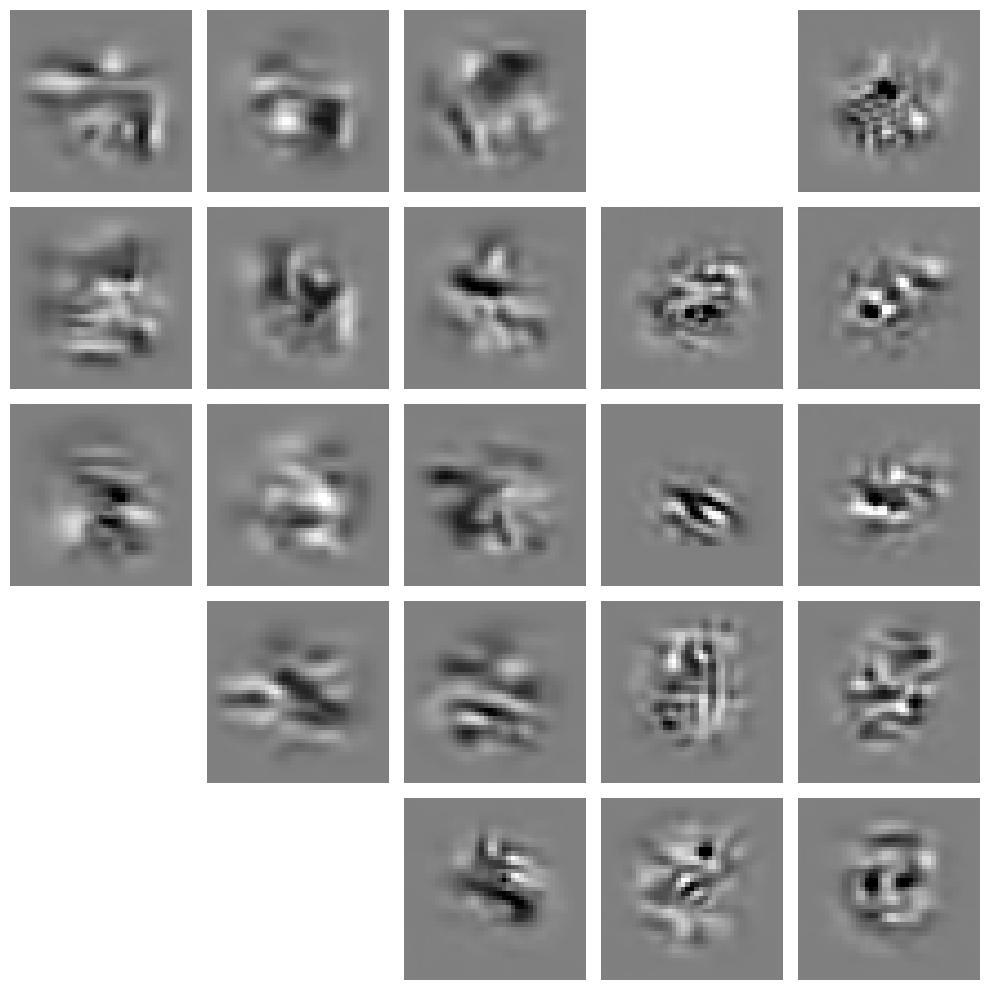

In [273]:
# Plot the selected MEIs at the grid locations

fig, axs = plt.subplots(N, N, figsize=(10, 10))

# Create a set of all subplot locations
all_locs = {(i, j) for i in range(N) for j in range(N)}

for i, (mei, loc) in enumerate(zip(selected_meis, selected_locs)):
    # Flip the loc vertically
    flipped_loc = (N - 1 - loc[1], loc[0])
    ax = axs[flipped_loc]
    ax.imshow(mei, cmap='gray', vmin=-1, vmax=1)
    ax.axis('off')

# Hide axes for empty subplots
for loc in all_locs - set(selected_locs):
    flipped_loc = (N - 1 - loc[1], loc[0])
    axs[flipped_loc].axis('off')

plt.tight_layout()

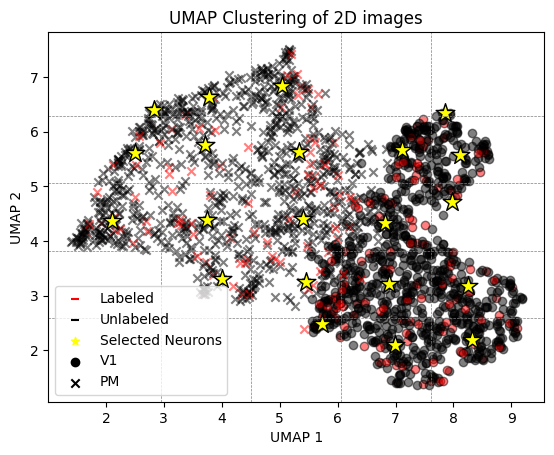

In [267]:
# Plot UMAP images with a separate color for labeled cells where redcell == 1

added_labels = []
for i, (label, redcell) in enumerate(zip(class_list, redcells)):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], 
                marker=markers[label], 
                alpha=0.5, 
                edgecolors='k', 
                color='red' if redcell == 1 else 'black',
                )
    added_labels.append(label)

# Add a label (*) for the selected neurons
for idx in selected_indices:
    plt.scatter(embeddings[idx, 0], embeddings[idx, 1], 
                marker='*', 
                s=200,  # size of the star marker
                color='yellow', 
                edgecolors='k')

# Draw the NxN grid
for i in range(1, N):
    plt.axhline(y=y[i], color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(x=x[i], color='gray', linestyle='--', linewidth=0.5)

legend_labels = ['V1', 'PM']
plt.scatter([], [], color='red', label='Labeled', marker='_')
plt.scatter([], [], color='black', label='Unlabeled', marker='_')
plt.scatter([], [], marker='*', color='yellow', label='Selected Neurons')

for i in range(2):
    plt.scatter([], [], marker=markers[i], label=legend_labels[i], color='black')

plt.title('UMAP Clustering of 2D images')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Avoid duplicate legend entries
plt.legend(loc='lower left')

plt.show()